# Packages

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

from importlib import reload
import split_vectorize
import base_models
import neural_nets

from IPython.display import display, HTML
from sklearn.metrics import f1_score

/home/carmen_east/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Get Data

Choose how many rows of data you want to work with by filling in the n value below.

In [2]:
n = 100000

Uncomment the line below to create a new data file with a random sample of `n` articles. Otherwise, skip to the next cell to import an existing file with `n` articles.

In [3]:
# THIS CODE BLOCK CAN TAKE A LONG TIME TO RUN... SKIP IT BY LOADING AN EXISTING FILE INSTEAD
# %run parse_corpus.py $n

In [4]:
df = pd.read_csv('data/nyt_corpus_'+str(n)+'.csv')
df.shape
df.head(3)

,abstract,author_info,copyright_holder,copyright_year,descriptor,desk,full_text,general_descriptor,headline,id,...,print_page_number,print_section,publication_day_of_month,publication_day_of_week,publication_month,publication_year,series_name,taxonomic_classifier,title,types_of_material
0,"Corel Corp, Ottawa-based software company, re...",NaN,The New York Times,1998.0,NaN,Business/Financial Desk,"The Corel Corporation, an Ottawa-based softwa...","['Company Reports', 'Computer Software', 'Copy...","Corel, a Rival Of Microsoft, Had a Bad Year",989253,...,3.0,D,21.0,Wednesday,1.0,1998.0,NaN,"['Top/News/Technology', 'Top/News/Business', '...","Corel, a Rival Of Microsoft, Had a Bad Year",NaN
1,"New York State Legislature, ending annual ses...",NaN,The New York Times,1998.0,NaN,Westchester Weekly Desk,STATE legislators ended their annual session ...,"['Budgets and Budgeting', 'Finances']",Most of County's Wish List Denied,1027868,...,7.0,14WC,28.0,Sunday,6.0,1998.0,NaN,"['Top/News/New York and Region', 'Top/News/New...",Most of County's Wish List Denied,NaN
2,NaN,NaN,The New York Times,2005.0,NaN,Classified,"CARLSON -- Kathleen Ann. Died on January 30, ...",NaN,"Paid Notice: Deaths CARLSON, KATHLEEN ANN",1647142,...,25.0,G,3.0,Thursday,2.0,2005.0,NaN,['Top/Classifieds/Paid Death Notices'],"Paid Notice: Deaths CARLSON, KATHLEEN ANN",['Paid Death Notice']


### Possible Model Outputs

There are multiple columns that could be used as the target variable in classification models. I will use `desk` since it has the lowest percentage of nulls and it never assigns multiple labels to an article.

In [5]:
df[['desk','general_descriptor','online_sections','taxonomic_classifier']][-5:]

,desk,general_descriptor,online_sections,taxonomic_classifier
99995,Financial Desk,"['Mergers, Acquisitions and Divestitures', 'Fi...",Business,['Top/News/Business']
99996,Metropolitan Desk,"['Robberies and Thefts', 'Stadiums and Arenas'...",New York and Region,"['Top/News/New York and Region', 'Top/News/Spo..."
99997,Editorial Desk,"['Ethics', 'Reform and Reorganization', 'Presi...",Opinion,"['Top/Opinion', 'Top/Opinion/Opinion', 'Top/Ne..."
99998,Connecticut Weekly Desk,NaN,New York and Region,"['Top/News/New York and Region', 'Top/News/New..."
99999,Home Desk,"['Jewels and Jewelry', 'Trade Shows and Fairs']",Home and Garden; Style,"['Top/Features/Home and Garden', 'Top/Features..."


Percentage of nulls for each of the possible label columns:

In [6]:
(n - df[['desk','general_descriptor','online_sections','taxonomic_classifier']].count()) / n

desk                    0.00339
general_descriptor      0.21148
online_sections         0.02267
taxonomic_classifier    0.01465
dtype: float64

# Preprocess Data

Uncomment the line below to run pre-processing on the parsed data file. Otherwise, skip to the next cell to import the existing preprocessed file.

In [7]:
# THIS CODE BLOCK CAN TAKE A LONG TIME TO RUN... SKIP IT BY LOADING AN EXISTING FILE INSTEAD
# %run preprocessing.py $n

In [8]:
df_final = pd.read_csv('data/nyt_corpus_cleaned_'+str(n)+'.csv')
print(df_final.shape)
df_final.head()

(100000, 7)


,desk,full_text,lead_paragraph,headline,nouns,lemmas,length
0,business & financial,"the corel corporation , an ottawa - based sof...","the corel corporation , an ottawa - based sof...","corel , a rival of microsoft , had a bad year",corel corporation ottawa software company batt...,"the corel corporation , an ottawa - base softw...",481.0
1,westchester weekly,state legislators ended their annual session e...,state legislators ended their annual session e...,most of county's wish list denied,state legislators session month county wishes ...,state legislator end their annual session earl...,952.0
2,classified,carlson - - kathleen ann . died on january...,carlson - - kathleen ann . died on january...,"paid notice : deaths carlson , kathleen ann",carlson kathleen ann sloan kettering hospital ...,"carlson - - kathleen ann . die on january 30 ,...",312.0
3,society,"judy ball morrill , a daughter of dewitt c . ...","judy ball morrill , a daughter of dewitt c . ...","judy morrill , randall taylor",judy ball morrill daughter c morrill southbury...,"judy ball morrill , a daughter of dewitt c . m...",182.0
4,sports,baseball american league tampa bay devil rays...,baseball american league tampa bay devil rays...,transactions,baseball league tampa bay devil roy silver man...,baseball american league tampa bay devil ray -...,434.0


The table below shows some examples of how the `desk` variable is cleaned.

In [9]:
label_transform = pd.concat([df_final.desk, df.desk], axis=1)
label_transform.columns = ['desk_cleaned', 'desk']
label_transform.groupby(['desk_cleaned','desk']).size().reset_index(name='cnt').set_index(['desk_cleaned','desk'])[15:45]

cnt
desk_cleaned         desk                                                 
arts & leisure       Weekend Desk                                     1002
                     Weekend DeskWeekend Desk                            5
book review          Book Review Desk                                 1750
                     Book Review Dest                                    1
boston 2004          Boston 2004                                         2
business & financial Business Desk                                       4
                     Business World Magazine                             8
                     Business/Financial Desk                          6078
                     Business/Financial Desk;                            1
                     Business/Financial desk                             1
                     Business/FinancialDesk                              5
                     Business\Financial Desk                             2
                     E-Business                                          6
                     E-Commerce                                         17
                     Financial Desk                                  11276
                     Financial Desk;                                    16
                     Financial Planning Guide: Personal Investing        1
                     Financial Planning Guide: Your Taxes                3
                     Money & Business/Financial Desk                     3
                     Money and Busines/Financial Desk                    1
                     Money and Business/Financial Desk                 939
                     Money and Business/Financial DeskMoney and Bus      3
                     Moneyand Business/Financial Desk                    1
                     Small Business                                     12
                     SundayBusiness                                     82
                     The Business of Green                               3
cars                 Automobiles                                       122
                     Cars                                               28
classified           Classfied                                           3
                     Classifed                                           8

### Train/Dev/Test Split and TF-IDF Vectorize

Here I create an object for each model input:

1. Full text
2. Lead paragraph
3. Headlines
4. Nouns
5. Lemmas

Throughout the rest of notebook, I will attach various statistics and models to each object.

Splitting Full Text


/home/carmen_east/w266-final-project/split_vectorize.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = self.df[[self.articles, self.labels]][self.df[self.articles].notnull()][self.df[self.labels].notnull()]


Vocab counting Full Text
Full Text: Scanned 1,000 articles 00:00:00
Full Text: Scanned 2,000 articles 00:00:02
Full Text: Scanned 3,000 articles 00:00:04
Full Text: Scanned 4,000 articles 00:00:08
Full Text: Scanned 5,000 articles 00:00:12
Full Text: Scanned 6,000 articles 00:00:17
Full Text: Scanned 7,000 articles 00:00:22
Full Text: Scanned 8,000 articles 00:00:26
Full Text: Scanned 9,000 articles 00:00:31
Full Text: Scanned 10,000 articles 00:00:36
Full Text: Scanned 11,000 articles 00:00:42
Full Text: Scanned 12,000 articles 00:00:46
Full Text: Scanned 13,000 articles 00:00:57
Full Text: Scanned 14,000 articles 00:01:10
Full Text: Scanned 15,000 articles 00:01:22
Full Text: Scanned 16,000 articles 00:01:35
Full Text: Scanned 17,000 articles 00:01:48
Full Text: Scanned 18,000 articles 00:02:03
Full Text: Scanned 19,000 articles 00:02:17
Full Text: Scanned 20,000 articles 00:02:31
Full Text: Scanned 21,000 articles 00:02:46
Full Text: Scanned 22,000 articles 00:03:01
Full Text: Scann

Headlines: Scanned 31,000 articles 00:00:17
Headlines: Scanned 32,000 articles 00:00:18
Headlines: Scanned 33,000 articles 00:00:18
Headlines: Scanned 34,000 articles 00:00:19
Headlines: Scanned 35,000 articles 00:00:20
Headlines: Scanned 36,000 articles 00:00:21
Headlines: Scanned 37,000 articles 00:00:22
Headlines: Scanned 38,000 articles 00:00:23
Headlines: Scanned 39,000 articles 00:00:23
Headlines: Scanned 40,000 articles 00:00:24
Headlines: Scanned 41,000 articles 00:00:25
Headlines: Scanned 42,000 articles 00:00:26
Headlines: Scanned 43,000 articles 00:00:27
Headlines: Scanned 44,000 articles 00:00:28
Headlines: Scanned 45,000 articles 00:00:29
Headlines: Scanned 46,000 articles 00:00:30
Headlines: Scanned 47,000 articles 00:00:31
Headlines: Scanned 48,000 articles 00:00:32
Headlines: Scanned 49,000 articles 00:00:34
Headlines: Scanned 50,000 articles 00:00:35
Headlines: Scanned 51,000 articles 00:00:36
Headlines: Scanned 52,000 articles 00:00:38
Headlines: Scanned 53,000 articl

Lemmatized: Scanned 65,000 articles 00:11:20
Lemmatized: Scanned 66,000 articles 00:11:36
Lemmatized: Scanned 67,000 articles 00:11:52
Lemmatized: Scanned 68,000 articles 00:12:08
Lemmatized: Scanned 69,000 articles 00:12:25
Lemmatized: Scanned 70,000 articles 00:12:42
Lemmatized: Scanned 71,000 articles 00:12:58
Lemmatized: Scanned 72,000 articles 00:13:14
Lemmatized: Scanned 73,000 articles 00:13:31
TF-IDF vectorizing Lemmatized


'Split-vectorizing complete'

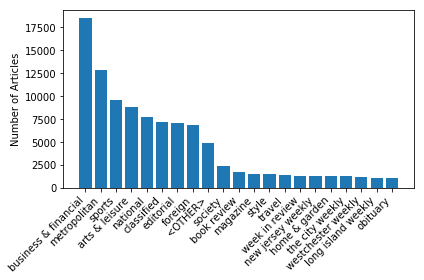

In [10]:
reload(split_vectorize)
rand_seed = 102 # Random number to feed in so all models will assign same articles to train/dev/test sets

# Create object for each of the model inputs
full_text = split_vectorize.SplitVectorize(df_final, 'full_text', 'Full Text')
lead_para = split_vectorize.SplitVectorize(df_final, 'lead_paragraph', 'Lead Paragraph')
headlines = split_vectorize.SplitVectorize(df_final, 'headline', 'Headlines')
nouns = split_vectorize.SplitVectorize(df_final, 'nouns', 'Nouns Only')
lemmas = split_vectorize.SplitVectorize(df_final, 'lemmas', 'Lemmatized')

all_inputs = [full_text, lead_para, headlines, nouns, lemmas]

# Split into train/test data and TF-IDF vectorize
for x in all_inputs:
    print('Splitting', x.name_)
    x.train_test_split(rand_seed)
    print('Vocab counting', x.name_)
    x.vocab_stats()
    print('TF-IDF vectorizing', x.name_)
    x.tfidf_vectorize()
'Split-vectorizing complete'

Percentage of articles NOT in the `<OTHER>` category:

In [11]:
for x in all_inputs:
    print('{}: {:.1%}'.format(x.name_, x.df[x.df.desk != '<OTHER>'].groupby('desk').count().sum()[0] / x.df.groupby('desk').count().sum()[0]))

Full Text: 95.1%
Lead Paragraph: 94.9%
Headlines: 95.1%
Nouns Only: 95.1%
Lemmatized: 95.1%


Key statistics for each type of data. Note the number of articles for each model input varies because sometimes certain inputs have missing data. However, the same articles are assigned to training/dev/test data for each input.

In [12]:
html = '<table><th>Article Type</th><th>Total Articles</th><th>Training Articles</th><th>Training Words</th><th>% Training Words</th>'
html += '<th>Avg. Words per Training Article</th><th>Training Vocab Size</th><th>% Training Vocab</th>'
html += '<th>Avg. Unique Words per Training Article</th><th>TF-IDF Train Vocab</th><th>Dev Articles</th><th>Test Articles</th></tr>'

for x in all_inputs:
    total = x.tv_train.shape[0] + x.tv_dev.shape[0] + x.tv_test.shape[0]
    html += '<tr><td>{}</td><td>{:,}</td><td>{:,}</td><td>{:,}</td>'.format(x.name_, total, x.train_data.shape[0], x.train_words_)
    html += '<td>{:.0%}</td><td>{:.0f}</td>'.format(x.train_words_/full_text.train_words_, x.train_avg_words_)
    html += '<td>{:,}</td><td>{:.0%}</td>'.format(x.train_vocab_size_, x.train_vocab_size_/full_text.train_vocab_size_)
    html += '<td>{:,.0f}</td><td>{:,}</td>'.format(x.train_avg_unq_words_, x.tv_train.shape[1])
    html += '<td>{:,}</td><td>{:,}</td></tr>'.format(x.dev_data.shape[0], x.test_data.shape[0])

html += '</table>'
display(HTML(html)) # 100k

Full Text,"98,636","73,990","49,461,663",100%,668,"327,417",100%,276,"129,165","4,959","19,687"
Lead Paragraph,"96,108","72,058","7,585,076",15%,105,"140,307",43%,67,"63,733","4,839","19,211"
Headlines,"99,944","74,989","570,419",1%,8,"42,318",13%,7,"19,724","5,031","19,924"
Nouns Only,"98,622","73,978","13,202,063",27%,178,"198,162",61%,111,"97,557","4,959","19,685"
Lemmatized,"98,636","73,990","50,471,696",102%,682,"236,730",72%,253,"113,923","4,959","19,687"


# Baseline Models

I use a Multinomial Naïve Bayes and Logistic Regression as simple baseline models. For each model and model input, I fit multiple models with different parameters values, and then optimize on the dev data. After finding the best models, I calculate the accuracy on the test data.

### Multinomial Naïve Bayes

Fit multiple MNB models on each of the model inputs, looking for the best value of `alpha`.

In [13]:
reload(base_models)
mnb = base_models.MultNB()

for x in all_inputs:
    print('Testing MNB models for', x.name_)
    mnb.test_models(x)
print('Model testing complete')

Testing MNB models for Full Text
	Full Text: tested alpha=2^-11 00:00:01
	Full Text: tested alpha=2^-10 00:00:02
	Full Text: tested alpha=2^-9 00:00:03
	Full Text: tested alpha=2^-8 00:00:04
	Full Text: tested alpha=2^-7 00:00:06
	Full Text: tested alpha=2^-6 00:00:07
	Full Text: tested alpha=2^-5 00:00:08
	Full Text: tested alpha=2^-4 00:00:09
	Full Text: tested alpha=2^-3 00:00:10
	Full Text: tested alpha=2^-2 00:00:11
	Full Text: tested alpha=2^-1 00:00:13
	Full Text: tested alpha=2^0 00:00:14
	Full Text: tested alpha=2^1 00:00:15
	Full Text: tested alpha=2^2 00:00:16
	Full Text: tested alpha=2^3 00:00:18
Testing MNB models for Lead Paragraph
	Lead Paragraph: tested alpha=2^-11 00:00:00
	Lead Paragraph: tested alpha=2^-10 00:00:00
	Lead Paragraph: tested alpha=2^-9 00:00:01
	Lead Paragraph: tested alpha=2^-8 00:00:01
	Lead Paragraph: tested alpha=2^-7 00:00:02
	Lead Paragraph: tested alpha=2^-6 00:00:02
	Lead Paragraph: tested alpha=2^-5 00:00:03
	Lead Paragraph: tested alpha=2^-4 0

Graph the accuracy on the dev data for each of the models tested.

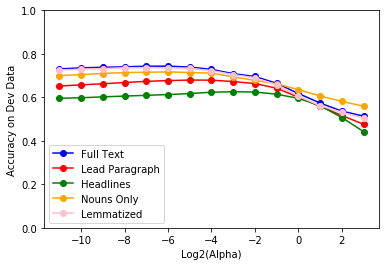

In [14]:
mnb_tables = []
for x in all_inputs:
    mnb_tables.append(x.mnb_accuracy_table_)

mnb.plot_accuracy(mnb_tables)

### Logistic Regression

Fit multiple LR models on each of the model inputs, looking for the best values of `C` and `penalty`.

In [15]:
# THIS CELL TAKES 7.5 HOURS TO RUN WHEN N=100K... RECOMMEND USING N=10K AS IT'S MUCH FASTER AND RESULTS ARE ALMOST AS GOOD
reload(base_models)
lr = base_models.LogReg()

for x in all_inputs:
    print('Testing LR models for', x.name_)
    lr.test_models(x)
print('Model testing complete')

Testing LR models for Full Text
	Full Text: tested penalty=l1 C=10^-6 00:00:27
	Full Text: tested penalty=l1 C=10^-5 00:00:53
	Full Text: tested penalty=l1 C=10^-4 00:01:35
	Full Text: tested penalty=l1 C=10^-3 00:02:34
	Full Text: tested penalty=l1 C=10^-2 00:03:45
	Full Text: tested penalty=l1 C=10^-1 00:05:20
	Full Text: tested penalty=l1 C=10^0 00:07:31
	Full Text: tested penalty=l1 C=10^1 00:13:04
	Full Text: tested penalty=l1 C=10^2 00:20:51
	Full Text: tested penalty=l1 C=10^3 00:25:49
	Full Text: tested penalty=l1 C=10^4 00:28:38
	Full Text: tested penalty=l1 C=10^5 00:31:17
	Full Text: tested penalty=l1 C=10^6 00:33:34
	Full Text: tested penalty=l2 C=10^-6 00:33:58
	Full Text: tested penalty=l2 C=10^-5 00:34:43
	Full Text: tested penalty=l2 C=10^-4 00:35:34
	Full Text: tested penalty=l2 C=10^-3 00:36:43
	Full Text: tested penalty=l2 C=10^-2 00:38:12
	Full Text: tested penalty=l2 C=10^-1 00:40:27
	Full Text: tested penalty=l2 C=10^0 00:44:01
	Full Text: tested penalty=l2 C=10^1

Graph the accuracy on the dev data for each of the models tested.

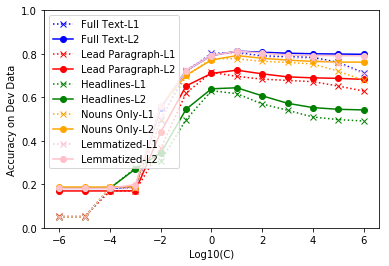

In [16]:
lr_tables = []
for x in all_inputs:
    lr_tables.append(x.lr_accuracy_table_)

lr.plot_accuracy(lr_tables)

### Key Statistics

For the best MNB and LR models for each of the possible inputs.

In [22]:
html = '<table><th>Model Input</th><th>MNB Parameters</th><th>MNB Dev Accuracy</th><th>MNB Test Accuracy</th>'
html += '<th>MNB Test F1</th>'
html += '<th>LR Parameters</th><th>LR Dev Accuracy</th><th>LR Test Accuracy</th><th>LR Test F1</th>'

for x in all_inputs:
    alpha = 'alpha = 2^'+str(np.log2(x.best_mnb_model_.alpha))
    html += '<tr><td>{}</td><td>{}</td><td>{:.3f}</td><td>{:.3f}</td>'.format(x.name_, alpha, max(x.mnb_accuracy_table_.accuracy), x.best_mnb_model_.score(x.tv_test, x.test_labels))
    html += '<td>{:.3f}</td>'.format(f1_score(x.test_labels, x.best_mnb_model_.predict(x.tv_test), average='weighted'))
    C = 'C = 10^'+str(np.log10(x.best_lr_model_.C))
    penalty = 'penalty = '+x.best_lr_model_.penalty
    html += '<td>{}</td><td>{:.3f}</td><td>{:.3f}</td>'.format(C+'; '+penalty, max(x.lr_accuracy_table_.accuracy), x.best_lr_model_.score(x.tv_test, x.test_labels))
    html += '<td>{:.3f}</td></tr>'.format(f1_score(x.test_labels, x.best_lr_model_.predict(x.tv_test), average='weighted'))

html += '</table>'
display(HTML(html))

Full Text,alpha = 2^-7.0,0.743,0.733,0.719,C = 10^1.0; penalty = l2,0.813,0.815,0.806
Lead Paragraph,alpha = 2^-5.0,0.679,0.687,0.667,C = 10^1.0; penalty = l2,0.725,0.730,0.716
Headlines,alpha = 2^-3.0,0.626,0.627,0.601,C = 10^1.0; penalty = l2,0.644,0.643,0.631
Nouns Only,alpha = 2^-6.0,0.717,0.721,0.706,C = 10^1.0; penalty = l2,0.792,0.792,0.783
Lemmatized,alpha = 2^-7.0,0.737,0.729,0.715,C = 10^1.0; penalty = l2,0.813,0.811,0.802


# Convolutional Neural Network

1. This model uses GloVe word embeddings to initialize the word embedding matrix.
2. For each of the model inputs, it uses the number of vocabulary words that were allowed in the TF-IDF vectorizer (default: drops words with document frequency = 1, since these tend to be misspellings or one-off words that don't contribute to helping the model learn the structure of each category).
3. For each of the model inputs, it pads each article to the smaller of:
    + The 90th percentile of lengths for that input type
    + 500

In [18]:
reload(neural_nets)
dp = neural_nets.DataPreparation()

for x in all_inputs:
    dp.tokenize(x)
    dp.pad(x)
    dp.create_glove_matrix(x)

Full Text:
	Training vocab size: 129,165
	90th percentile of length = 1,225 --> inputs padded to 500.
	Vocab reduced to 125,020 by padding operation (-3%)
	Training data shape: (73990, 500)
	Created GloVe matrix of 100-dimensional embeddings
Lead Paragraph:
	Training vocab size: 63,733
	90th percentile of length = 135 --> inputs padded to 135.
	Vocab reduced to 62,609 by padding operation (-2%)
	Training data shape: (72058, 135)
	Created GloVe matrix of 100-dimensional embeddings
Headlines:
	Training vocab size: 19,724
	90th percentile of length = 10 --> inputs padded to 10.
	Vocab reduced to 19,682 by padding operation (-0%)
	Training data shape: (74989, 10)
	Created GloVe matrix of 100-dimensional embeddings
Nouns Only:
	Training vocab size: 97,557
	90th percentile of length = 374 --> inputs padded to 374.
	Vocab reduced to 96,682 by padding operation (-1%)
	Training data shape: (73978, 374)
	Created GloVe matrix of 100-dimensional embeddings
Lemmatized:
	Training vocab size: 113,923

In [45]:
reload(neural_nets)
cnn = neural_nets.CNN()
for x in all_inputs:
    kernel_size = [4,3,2] if x == headlines else [20,10,5]
    cnn.cnn(x, kernel_size=kernel_size)


FULL TEXT:

Epoch 1/5
73990/73990 [==============================] - 326s 4ms/step - loss: 1.4014 - acc: 0.5860
Epoch 2/5
73990/73990 [==============================] - 324s 4ms/step - loss: 0.9823 - acc: 0.7097
Epoch 3/5
73990/73990 [==============================] - 323s 4ms/step - loss: 0.7883 - acc: 0.7620
Epoch 4/5
73990/73990 [==============================] - 322s 4ms/step - loss: 0.6236 - acc: 0.8091
Epoch 5/5
19687/19687 [==============================] - 13s 685us/step
Test accuracy: 0.6869507797083969
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 500, 100)          32741900  
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 481, 4)            8004      
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 472, 16)           656       
___________________

73990/73990 [==============================] - 283s 4ms/step - loss: 1.0374 - acc: 0.6875
Epoch 3/5
73990/73990 [==============================] - 285s 4ms/step - loss: 0.8576 - acc: 0.7415
Epoch 4/5
73990/73990 [==============================] - 287s 4ms/step - loss: 0.7158 - acc: 0.7820
Epoch 5/5
19687/19687 [==============================] - 14s 705us/step
Test accuracy: 0.7005638238492005
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 500, 100)          23673200  
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 481, 4)            8004      
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 472, 16)           656       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 236, 16)           0         
__________

### Key Statistics

In [46]:
html = '<table><th>Model Input</th><th>Training Vocab</th><th>Padding Size</th>'
html += '<th>Vocab After Padding</th><th>CNN Test Accuracy</th><th>CNN Test F1</th>'

for x in all_inputs:
    html += '<tr><td>{}</td><td>{:,}</td><td>{:,}</td>'.format(x.name_, x.tv_train.shape[1], x.train_ids.shape[1])
    html += '<td>{:,}</td><td>{:.3f}</td>'.format(x.nn_effective_vocab_, x.cnn_accuracy_)
    html += '<td>{:.3f}</td></tr>'.format(f1_score(x.test_labels.apply(lambda z: x.label_ids[z]), np.argmax(x.cnn_model_.predict(x.test_ids), axis=1), average='weighted'))

html += '</table>'
display(HTML(html))

/home/carmen_east/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Full Text,"129,165",500,"125,020",0.687,0.669
Lead Paragraph,"63,733",135,"62,609",0.640,0.623
Headlines,"19,724",10,"19,682",0.579,0.567
Nouns Only,"97,557",374,"96,682",0.690,0.680
Lemmatized,"113,923",500,"106,573",0.701,0.688


# Error Analysis

With more time or additional group members, this would have been my next step to keep improving the models.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
for x in all_inputs:
    print('\n', x.name_, ':')
    print(classification_report(x.dev_labels, x.best_mnb_model_.predict(x.tv_dev)))
    print(confusion_matrix(x.dev_labels, x.best_mnb_model_.predict(x.tv_dev), labels=list(x.dev_labels.unique())))